# OCR Bengali

# Introduction

*All the information in this introduction is from Bengali.AI Community. Posted in Kaggle.*

A grapheme is the smallest unit of a writing system for any language. The definition of grapheme for English is tied to how phonemes are defined / spoken.

Bangla graphemes are a combination of following units:

1) **Grapheme roots**, which can be vowels, consonants or conjuncts. There are up to 168 unique grapheme roots.

2) **Vowel diacritics**: up to 11 unique values (including null)

3) **Consonant diacritics**: up to 7 unique values (including null)

To sum up:

<img src="Info/Bangali graphemes.png" width="800">

File **Info/class_map.csv** contains the labelling for each unit.


# Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math as math
import tensorflow_addons as tfa
from tqdm.auto import tqdm

# Data

**X data**
Images are in 4 files: "train_image_data_{i}.parquet". Each file contains a matrix with one image is in each row. Images are 137 x 236 pixels. Pixels range: (0,255). Images are grayscale (one channel).

**Y data**
Labels are in file: "train.csv".

Column 0: training sample number

Column 1: grapheme root label

Column 2: vowel diacritic label

Column 3: consonant diacritic label

In [2]:
## Path to data folder
PATH_DATA = "Data/"

In [3]:
## Downloading labels
df = pd.read_csv(PATH_DATA+"train.csv")
y_train=np.array(df.iloc[:,1:4])
del df
print("Shape of label matrix y_train is: (%d,%d)" %y_train.shape)

Shape of label matrix y_train is: (200840,3)


In [4]:
# Images size
HEIGHT = 137
WIDTH = 236
N_CHANNEL = 1

TRAIN = ['train_image_data_0.parquet',
         'train_image_data_1.parquet',
         'train_image_data_2.parquet',
         'train_image_data_3.parquet']

df = pd.read_parquet(PATH_DATA+TRAIN[0])
x_train = df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH,N_CHANNEL)
del df
print("Shape of data matrix x_train is: (%d,%d,%d,%d)" %x_train.shape)


Shape of data matrix x_train is: (50210,137,236,1)


## Understanding the data
Observe that the data is inverted (white background)

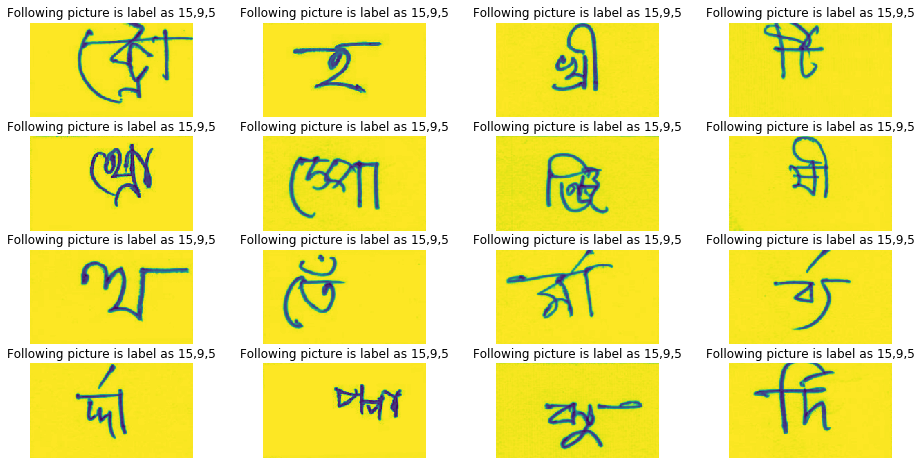

In [5]:
example2plot=0
cols, rows = 4, 4
img_num = cols * rows
fig, ax = plt.subplots(nrows=cols, ncols=rows, figsize=(16, 8))
for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_train[example2plot+i,:,:,0], interpolation="nearest")
    plt.title("Following picture is label as %d,%d,%d" % (y_train[example2plot,0],y_train[example2plot,1],y_train[example2plot,2]))
    plt.axis('off')

## Downloading all data

Data is divided in training (90%) and cross validation (10%). Test data is obtained directly from KAGGLE submission.


In [6]:
del x_train

df0 = pd.read_parquet(PATH_DATA + TRAIN[0])
print(TRAIN[0]+" downloaded")
df1 = pd.read_parquet(PATH_DATA + TRAIN[1])
print(TRAIN[1]+" downloaded")
df=pd.concat([df0,df1], axis=0, join='outer', ignore_index=True)
del df0
del df1
df2 = pd.read_parquet(PATH_DATA + TRAIN[2])
print(TRAIN[2]+" downloaded")
df=pd.concat([df,df2], axis=0, join='outer', ignore_index=True)
del df2
df3 = pd.read_parquet(PATH_DATA + TRAIN[3])
print(TRAIN[3]+" downloaded")
df=pd.concat([df,df3], axis=0, join='outer', ignore_index=True)
del df3

x_train=df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH,N_CHANNEL)
print("Total training data x_train has shape: (%d,%d,%d,%d)" %x_train.shape)
del df

## Training / CV division
X_train, X_CV, Y_train0, Y_CV0, Y_train1, Y_CV1, Y_train2, Y_CV2 = train_test_split(x_train, (y_train[:,0]).reshape(-1,1), (y_train[:,1]).reshape(-1,1), (y_train[:,2]).reshape(-1,1), test_size=0.1, random_state=1)
del x_train
del y_train

train_image_data_0.parquet downloaded
train_image_data_1.parquet downloaded
train_image_data_2.parquet downloaded
train_image_data_3.parquet downloaded
Total training data x_train has shape: (200840,137,236,1)


## Resize & normalization function

Image initial shape: (16,137,236,1)
Image final shape: (16,128,128,1)


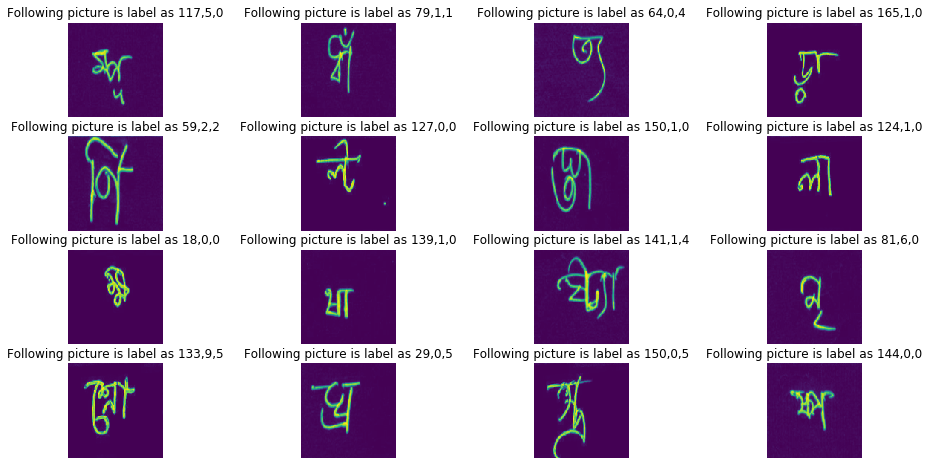

In [7]:
def resize(X,size=128):
    ## This function resizes each image to size x size. It also inverses the image and normalize it. 
    ## INPUT
    ##### X numpy array of 4D: (training samples, X, Y, Channels)
    ##### size: new size of image
    ## OUTPUT
    ##### XP tf tensor: X resized and normalized
    X=tf.math.divide(tf.subtract(255.0,X),255.0)
    XP=tf.image.resize(X,[size,size])
    return XP

## Testing resize()
cols, rows = 4, 4
img_num = cols * rows

XX=X_train[example2plot:example2plot+img_num,:,:,:]
print("Image initial shape: (%d,%d,%d,%d)" %XX.shape)
XX=resize(XX,128).numpy()  
print("Image final shape: (%d,%d,%d,%d)" %XX.shape) 

fig, ax = plt.subplots(nrows=cols, ncols=rows, figsize=(16, 8))
for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(XX[i,:,:,0], interpolation="nearest")
    plt.title("Following picture is label as %d,%d,%d" % (Y_train0[example2plot+i],Y_train1[example2plot+i],Y_train2[example2plot+i]))
    plt.axis('off')

**Resizing of all images**

In [8]:
# Resize to SIZE x SIZE
SIZE=128

print("X_CV shape: (%d,%d,%d,%d)" %X_CV.shape)

# Batch size for resizing
bs=512

xaux_list=[]
for i in tqdm(range(math.ceil(X_CV.shape[0]/bs))):
    xaux=resize(X_CV[i*bs:(i+1)*bs,:,:,:],SIZE)
    xaux_list.append(xaux)
XR_CV=np.vstack(xaux_list)
del xaux_list
print("XR_CV shape: (%d,%d,%d,%d)" %XR_CV.shape)

# If memory exceed problems:
# del X_CV

print("X_train shape: (%d,%d,%d,%d)" %X_train.shape)
xaux_list=[]
for i in tqdm(range(math.ceil(X_train.shape[0]/bs))):
    xaux=resize(X_train[i*bs:(i+1)*bs,:,:,:],SIZE)
    xaux_list.append(xaux)
XR_train=np.vstack(xaux_list)
del xaux_list
print("XR_train shape: (%d,%d,%d,%d)" %XR_train.shape)

# If memory exceed problems:
# del X_train



X_CV shape: (20084,137,236,1)



XR_CV shape: (20084,128,128,1)
X_train shape: (180756,137,236,1)



XR_train shape: (180756,128,128,1)


# Model

In [9]:
## INPUT layer
inputs = tf.keras.layers.Input(shape = (SIZE,SIZE,1))

## Convolution layer to fit pre-trained model
model = tf.keras.layers.Conv2D(3, (3,3),padding="same")(inputs)

## Pre-trained model: DenseNet121 / DenseNet169 / ResNet50V2 ...
IMG_SHAPE = (SIZE, SIZE, 3)
PreTrained_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')
model = PreTrained_model(model)

## Drop-out probability
drop_prob=0.5

## Preparation for dense layers
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.Dropout(drop_prob)(model)
model = tf.keras.layers.Flatten()(model)

## Dense layers
model = tf.keras.layers.Dense(256)(model)
model = tf.keras.layers.BatchNormalization()(model)
model = tf.keras.layers.ReLU()(model)
model = tf.keras.layers.Dropout(drop_prob)(model)

grapheme = tf.keras.layers.Dense(168, activation=tf.nn.softmax,name='grapheme')(model)
vowel = tf.keras.layers.Dense(11, activation=tf.nn.softmax,name='vowel')(model)
consonant = tf.keras.layers.Dense(7, activation=tf.nn.softmax,name='consonant')(model)
model = tf.keras.Model(inputs=inputs, outputs=[grapheme, vowel, consonant])
model.summary()

## Compilation
model.compile(optimizer = tf.optimizers.Adam(),
              loss = ['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
              metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 3)  30          input_1[0][0]                    
__________________________________________________________________________________________________
densenet121 (Model)             (None, 4, 4, 1024)   7037504     conv2d[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[1][0]                
______________________________________________________________________________________________

# Running

## Run without augmentation

In [10]:
'''model.fit(XR_train,[Y_train0, Y_train1,Y_train2],
          epochs=20,
          validation_data = (XR_CV, [Y_CV0, Y_CV1, Y_CV2]),
          batch_size=32)
'''

'model.fit(XR_train,[Y_train0, Y_train1,Y_train2],\n          epochs=20,\n          validation_data = (XR_CV, [Y_CV0, Y_CV1, Y_CV2]),\n          batch_size=32)\n'

## Run with augmentation

### Augmentation generators

This augmentation generators are a variation of https://github.com/yu4u/mixup-generator:

Augmentation includes:

**Mix-up**: The original algorithm uses Mix-up with labels in one-hot form, here it was modified to be used in sparse categorical. Each training image shall be the averaged sum of two images $X_1$ (main image) and $X_2$ (secondary image), $X = X_1 · f + X_2 · (1-f)$, the factor f must be large enough (between about 0.75-1.0). The labels are not averaged, the model only tries to predict $X_1$ labels and $X_2$ is used just as noise or as a way to try to confuse the model.

**Random-erasing**: A rectangle of the image is randomly erased. It can be erased to 0 or to random uniform values.

**Usual augmentation methods of Tensorflow**

License is included:

*MIT License

*Copyright (c) 2017 Yusuke Uchida*

*Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:*

*The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.*

*THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.*

In [11]:
## Class for MixUp
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = np.random.uniform(0.75,1)#l.reshape(self.batch_size, 1, 1, 1)
        y_l = 1#l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1)# * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1# * y_l + y2 * (1 - y_l)

        return X, y
    
## Function for random erasing
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = np.random.rand(h,w,input_img.shape[2])*(v_h-v_l)+v_l

        return input_img

    return eraser

[0]


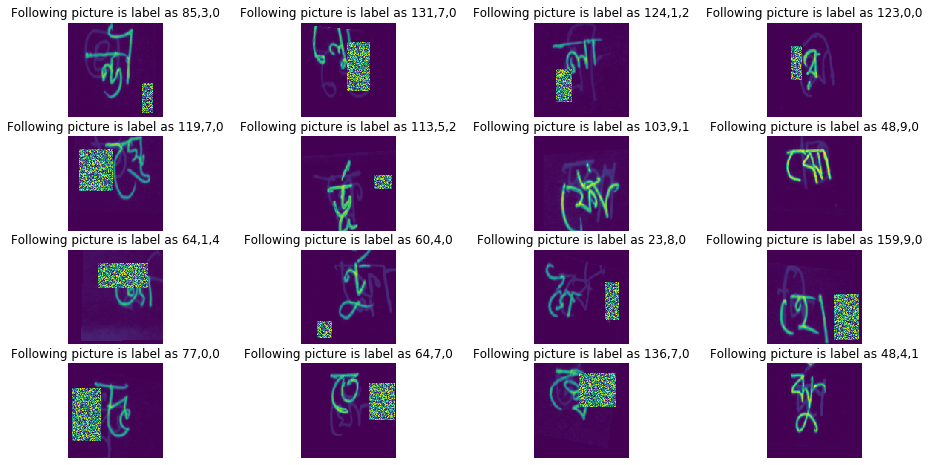

In [12]:
## Batch size for model fitting
batchsize=64

## Creation of augmentation generator
datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=False,
    shear_range=10,
    rotation_range=10,
    fill_mode='constant',
    cval=0,
    preprocessing_function=get_random_eraser(p=0.8, s_l=0.02, s_h=0.2, r_1=0.3, r_2=1/0.3, v_l=0, v_h=1))


training_generator = MixupGenerator(XR_train,
                                    [Y_train0, Y_train1,Y_train2],
                                    batch_size=batchsize,
                                    alpha=2,
                                    datagen=datagen)()

## To train instead with training and CV data (for final submission after tunning)
## training_generator = MixupGenerator(np.vstack((XR_train,XR_CV)),
#                                       [np.vstack((Y_train0,Y_CV0)), np.vstack((Y_train1,Y_CV1)),np.vstack((Y_train2,Y_CV2))],
#                                       batch_size=batchsize,
#                                       alpha=2,
#                                       datagen=datagen)()

## Plotting of sample images
x, y = next(training_generator)
print(y[2][0])
cols, rows = 4, 4
img_num = cols * rows
fig, ax = plt.subplots(nrows=cols, ncols=rows, figsize=(16, 8))
for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x[i,:,:,0], interpolation="nearest")
    plt.title("Following picture is label as %d,%d,%d" %(y[0][i],y[1][i],y[2][i]))
    plt.axis('off')

### Callbacks

In [13]:
## REDUCTION LEARNING RATE ON PLATEAU
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_grapheme_accuracy', 
                                                               patience=3, 
                                                               verbose=1, 
                                                               factor=0.5, 
                                                               min_lr=0.00001)

## EARLY STOPPING
callback_earlyS = tf.keras.callbacks.EarlyStopping(monitor='val_grapheme_accuracy', patience=7) 

## Nice plotting of progressbar
tqdm_callbacks = tfa.callbacks.TQDMProgressBar()

## Checkpoint everytime grapheme_accuracy is maximum
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                            filepath=checkpoint_filepath,
                            save_weights_only=True,
                            monitor='val_grapheme_accuracy',
                            mode='max',
                            save_best_only=True)

### Run

In [14]:
model.fit(training_generator,
           steps_per_epoch=XR_train.shape[0] // batchsize,
           validation_data = (XR_CV, [Y_CV0, Y_CV1, Y_CV2]),
           epochs=2,
           verbose=0,
           callbacks=[learning_rate_reduction,callback_earlyS,model_checkpoint_callback,tqdm_callbacks])

## Load last best weights
model.load_weights(checkpoint_filepath)

Epoch 1/2



Epoch 2/2


## Save model

In [15]:
PATH_MODEL="Trained models/"
## Save the model if desired
model.save(PATH_MODEL+'OCR_BANGALI.h5')

## Test the model and check in which images fails

In [16]:
Y_pred0,Y_pred1,Y_pred2=model.predict(XR_CV)
Y0=Y_pred0.argmax(axis=1).reshape(-1,1)
Y1=Y_pred1.argmax(axis=1).reshape(-1,1)
Y2=Y_pred2.argmax(axis=1).reshape(-1,1)

print("Grapheme accuracy: ",((Y0==Y_CV0).sum()/Y0.shape[0]))
print("Vowel accuracy: ",((Y1==Y_CV1).sum()/Y0.shape[0]))
print("Consonant accuracy: ",((Y2==Y_CV2).sum()/Y0.shape[0]))

prediction=((Y0==Y_CV0)&(Y1==Y_CV1)&(Y2==Y_CV2))
print("Total accuracy: ",(prediction.sum()/Y0.shape[0]))

Grapheme accuracy:  0.8931487751443935
Vowel accuracy:  0.9751045608444533
Consonant accuracy:  0.9734614618601872
Total accuracy:  0.8623282214698267


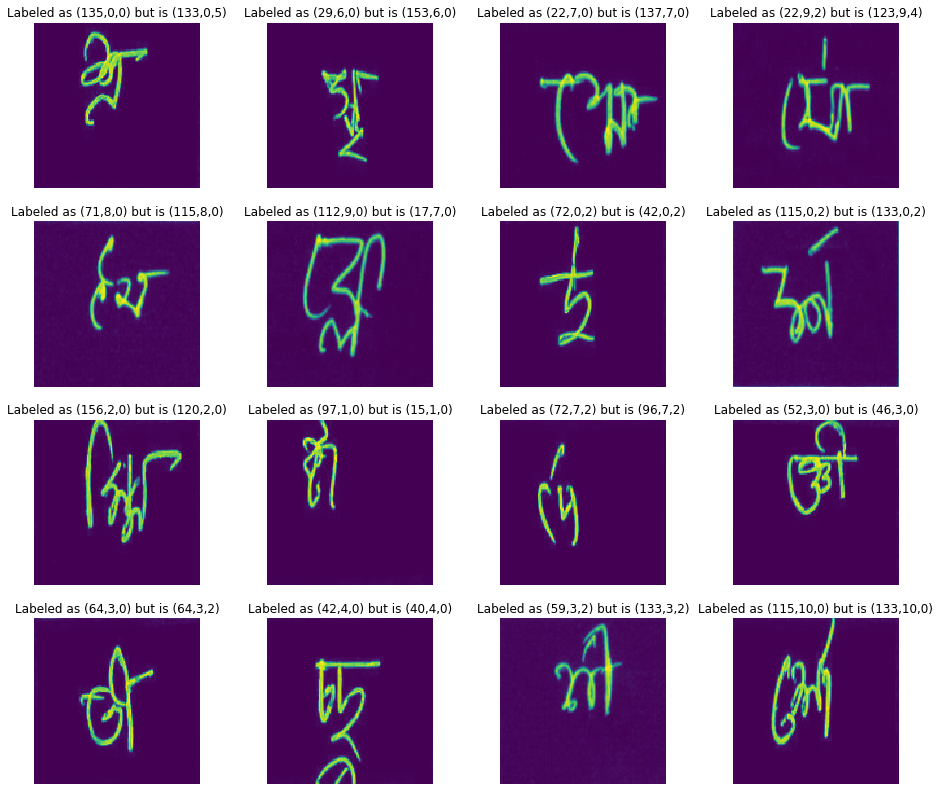

In [17]:
Xfailed=XR_CV[prediction[:,0]==0][:]
Y0failed=Y0[prediction[:,0]==0][:]
Y1failed=Y1[prediction[:,0]==0][:]
Y2failed=Y2[prediction[:,0]==0][:]
Y0real=Y_CV0[prediction[:,0]==0][:]
Y1real=Y_CV1[prediction[:,0]==0][:]
Y2real=Y_CV2[prediction[:,0]==0][:]

elem=0
## Plotting of sample images
cols, rows = 4, 4
img_num = cols * rows
fig, ax = plt.subplots(nrows=cols, ncols=rows, figsize=(16, 14))
for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(Xfailed[elem+i,:,:,0], interpolation="nearest")
    plt.title("Labeled as (%d,%d,%d) but is (%d,%d,%d)" %(Y0failed[elem+i],Y1failed[elem+i],Y2failed[elem+i],Y0real[elem+i],Y1real[elem+i],Y2real[elem+i]))
    plt.axis('off')

## Load model from library

In [18]:
## Load a model
model_2=tf.keras.models.load_model(PATH_MODEL+'OCRB128_DenseNet121_V20200225.h5')
model_2.compile(optimizer = tf.optimizers.Adam(),
                loss = ['sparse_categorical_crossentropy','sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
                metrics=['accuracy'])
model_2.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 128, 128, 3)  30          input_44[0][0]                   
__________________________________________________________________________________________________
densenet121 (Model)             (None, 4, 4, 1024)   7037504     conv2d_35[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d_15 (Gl (None, 1024)         0           densenet121[1][0]                
___________________________________________________________________________________________

**Test the loaded models**

Take into account that the trained models were trained in CV as well once tunning was made.

In [19]:
Y_pred0,Y_pred1,Y_pred2=model_2.predict(XR_CV)
Y0=Y_pred0.argmax(axis=1).reshape(-1,1)
Y1=Y_pred1.argmax(axis=1).reshape(-1,1)
Y2=Y_pred2.argmax(axis=1).reshape(-1,1)

print("Grapheme accuracy: ",((Y0==Y_CV0).sum()/Y0.shape[0]))
print("Vowel accuracy: ",((Y1==Y_CV1).sum()/Y0.shape[0]))
print("Consonant accuracy: ",((Y2==Y_CV2).sum()/Y0.shape[0]))

prediction=((Y0==Y_CV0)&(Y1==Y_CV1)&(Y2==Y_CV2))
print("Total accuracy: ",(prediction.sum()/Y0.shape[0]))

Grapheme accuracy:  0.9844154550886277
Vowel accuracy:  0.9957677753435571
Consonant accuracy:  0.9959171479784903
Total accuracy:  0.9780920135431189


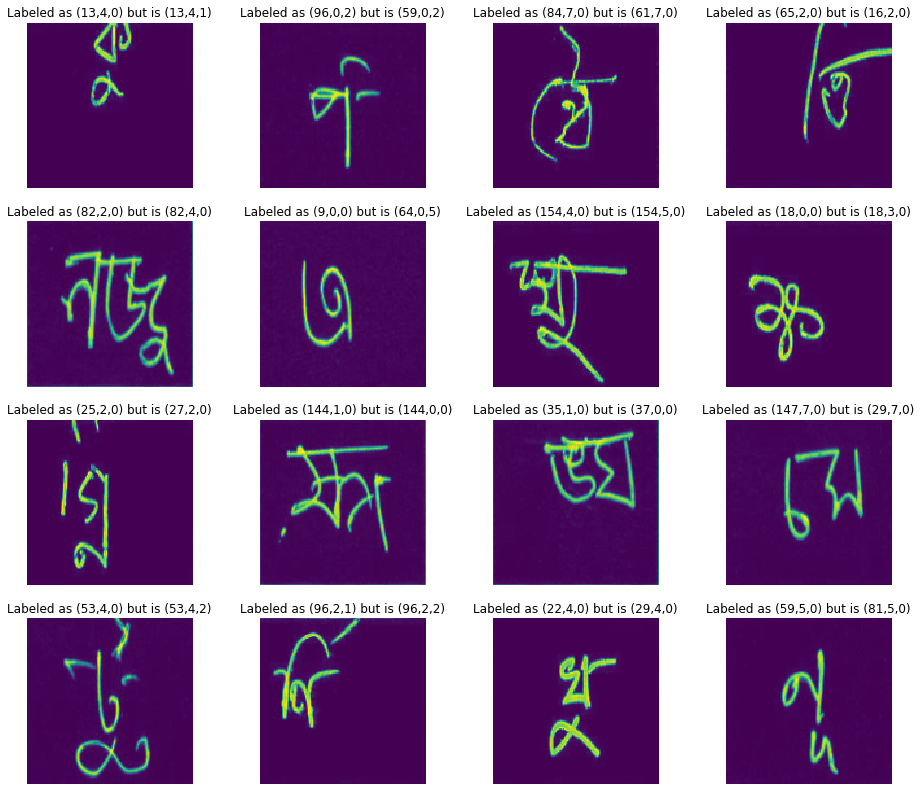

In [20]:
Xfailed=XR_CV[prediction[:,0]==0][:]
Y0failed=Y0[prediction[:,0]==0][:]
Y1failed=Y1[prediction[:,0]==0][:]
Y2failed=Y2[prediction[:,0]==0][:]
Y0real=Y_CV0[prediction[:,0]==0][:]
Y1real=Y_CV1[prediction[:,0]==0][:]
Y2real=Y_CV2[prediction[:,0]==0][:]

elem=0
## Plotting of sample images
cols, rows = 4, 4
img_num = cols * rows
fig, ax = plt.subplots(nrows=cols, ncols=rows, figsize=(16, 14))
for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(Xfailed[elem+i,:,:,0], interpolation="nearest")
    plt.title("Labeled as (%d,%d,%d) but is (%d,%d,%d)" %(Y0failed[elem+i],Y1failed[elem+i],Y2failed[elem+i],Y0real[elem+i],Y1real[elem+i],Y2real[elem+i]))
    plt.axis('off')